<a href="https://colab.research.google.com/github/IHMilon/CNN-Image-Classification-Portfolio/blob/main/ResNet_CIFAR100/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ResNet on CIFAR-100**

In this project, I implement and train a **Residual Neural Network (ResNet)** on the **CIFAR-100 dataset**.  
The goal is to explore the effectiveness of deep residual learning in classifying 100 object categories.

---

## Overview
- **Dataset**: CIFAR-100 (60,000 images, 32×32, 100 classes)  
- **Architecture**: ResNet inspired custom model.  
- **Objective**: Achieve high classification accuracy with proper training pipeline

## **Install Required Package**

In [7]:
!pip install torchprofile 1>/dev/null

## **Import Libraries**

In [8]:
import random
import time
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from torchprofile import profile_macs
from sklearn.metrics import confusion_matrix
from collections import namedtuple
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import OneCycleLR

## **Reproducibility**

In [3]:
seed = 40
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## **Device Setup**

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device is : {device}")

Device is : cuda


## **Images Transformations**
I apply Data Transformation to increase the size of training data, since **CIFAR-100** contains only 600 images per class. It will also improve the model performance and generalization.

In [10]:
# Train transformation
train_transforms = transforms.Compose([
      transforms.RandomCrop(32, padding = 4),
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.RandAugment(num_ops=2, magnitude=9),
      transforms.ToTensor()
      ])

# Test transformation
test_transforms = transforms.Compose([
      transforms.ToTensor()
      ])

## **Load the Dataset**
I use the pytorch CIFAR100 dataset. Which contains 60k (32, 32) color images. Where,
- **Training data :** 50k images are used for training.
- **Test data :** 10k images are used for testing.

There are total 100 classes and each one contains 600 images. Batch size is kept little bit of higher to make the learning smooth.

In [11]:
# Prepare Training set
train_set = datasets.CIFAR100(root = "data/cifar100", train = True, download= True, transform = train_transforms)
train_loader = DataLoader(train_set, batch_size = 128, shuffle = True, pin_memory = True)

# Prepare Test set
test_set = datasets.CIFAR100(root = "data/cifar100", train = False, download = True, transform = test_transforms)
test_loader = DataLoader(test_set, batch_size = 128, shuffle = False, pin_memory = True)

## **Inspect the proper Batch loading**

In [12]:
# Get single batch
train_batch = next(iter(train_loader))
#Extract images and labels from the batch
images, targets = train_batch
print(f"Images shape : {images.shape}")
print(f"Targets shape : {targets.shape}")

Images shape : torch.Size([128, 3, 32, 32])
Targets shape : torch.Size([128])


### **Visualize the Batch**
We can visualize few data from a batch to ensure all transformation works properly.

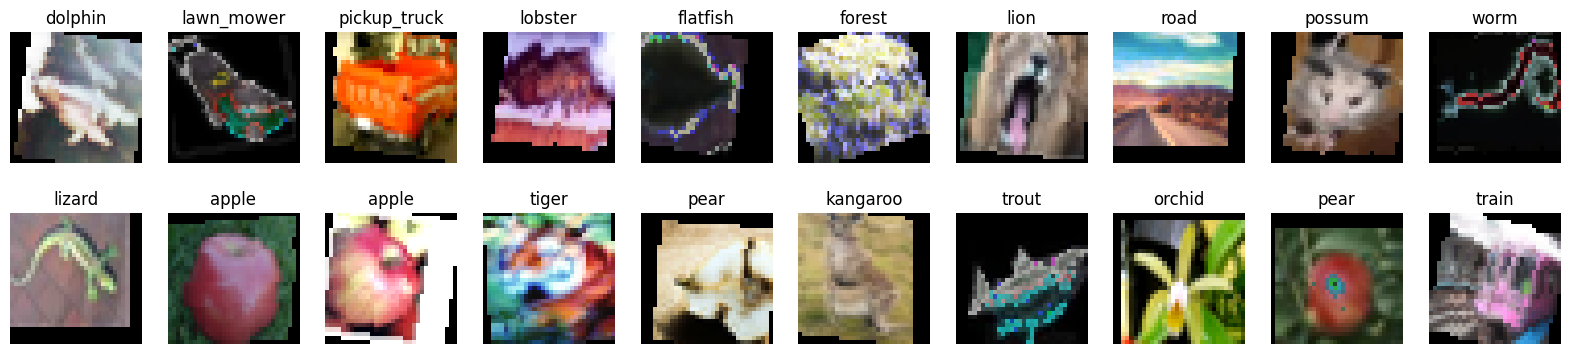

In [13]:
plt.figure(figsize = (20,9))
for i in range (20):
    image = images[i]
    label = targets[i]

    # Get label name from label index
    class_name = train_set.classes[label]

    # Convert CHW to HWC for imshow
    image = image.permute(1,2,0).numpy()

    # Plot the image
    plt.subplot(4, 10, i+1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis("off")
plt.show()

## **Define the Model**

### **Squeeze and Excitation (SE) Block**
It learns which channels are important and give them high weights and suppress less important ones. So that the model learns more efficiently.

In [14]:
# Define the SE Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction = 4):
        super().__init__()

        self.fc1 = nn.Conv2d(in_channels, in_channels//reduction, kernel_size = 1, bias = False)
        self.fc2 = nn.Conv2d(in_channels//reduction, in_channels, kernel_size = 1, bias = False)

        self.relu = nn.ReLU(inplace = True)
        self.sigmoid = nn.Sigmoid()
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

    def forward (self, x):
        input = x
        x = self.avgpool(x)  # (B, C, 1, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return input*x


### **CBAM (Convolutional Block Attention)**
It sequentially applies *channel and spatial attention* to feature maps. Which let's the model to focus on *important channels and spatial regions* improving the model performance.

In [ ]:
# Channel Attention Block
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction = 16):
        super().__init__()

        # These gives two types of info to work with
        self.avg_pool = nn.AdaptiveAvgPool2d(1,1)
        self.max_pool = nn.AdaptiveMaxPool2d(1,1)

        # Used conv2d to work with 4d tensor
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out) * x

# Spatial Attention
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):

        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Compute channel-wise max and average
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(concat)
        return self.sigmoid(out) * x

# CBAM Block
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_atten = ChannelAttention(in_channels, reduction)
        self.spatial_atten = SpatialAttention(kernel_size)

    def forward(self, x):
        out = self.channel_att(x)
        out = self.spatial_att(out)
        return out

### **Resnet Basic Block**
It is consist of two `conv-bn-relu` layer with (3×3) kernel. Also skip connection is defined here.

In [15]:
# Build the BasicBlock
class BasicBlock(nn.Module):
    expansion= 1
    def __init__(self, in_channel, channel, stride = 1):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel = channel
        self.stride = stride

        self.conv1 = nn.Conv2d(self.in_channel, self.out_channel, kernel_size = 3, padding = 1, stride = self.stride, bias = False)
        self.bn1 = nn.BatchNorm2d(channel)
        self.relu = nn.ReLU(inplace = True)

        self.conv2 = nn.Conv2d(self.out_channel, self.out_channel, kernel_size = 3, padding = 1, stride = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(channel)

        # SE Block
        #self.se = SEBlock(self.out_channel, reduction = 16)

        # Skip Connection
        if self.stride != 1 or self.in_channel != self.out_channel:
            self.skip = nn.Sequential(
                 nn.Conv2d(self.in_channel, self.out_channel, kernel_size = 1, stride = stride, bias = False),
                 nn.BatchNorm2d(channel))
        else:
            self.skip = nn.Identity()

    def forward(self, x):

        skip = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        #x = self.se(x)   # SE Block
        # Skip Connection
        if self.stride != 1 or self.in_channel != self.out_channel:
            skip = self.skip(skip)
        else:
            skip = self.skip(skip)

        x += skip
        x = self.relu(x)
        return x

### **ResNet Bottleneck Block**
It consists of three `conv-bn-relu` layers with (1×1 => 3×3 => 1×1) kernels and a skip connection.

In [ ]:
# Build the Bottleneck Block
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channel, channel, stride):
        super().__init__()

        self.in_channel = in_channel
        self.out_channel = channel
        self.stride = stride

        self.conv1 = nn.Conv2d(self.in_channel, self.out_channel, kernel_size = 1, stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(self.out_channel)

        self.conv2 = nn.Conv2d(self.out_channel, self.out_channel, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(self.out_channel)

        self.conv3 = nn.Conv2d(self.out_channel, self.expansion*self.out_channel, kernel_size = 1, stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion*self.out_channel)

        self.relu = nn.ReLU(inplace = True)

        # SE Block
        self.se = SEBlock(self.expansion*self.out_channel, reduction=16)

        if self.stride != 1 or self.in_channel != self.expansion*self.out_channel:
            self.skip = nn.Sequential(
                 nn.Conv2d(self.in_channel, self.expansion*self.out_channel, kernel_size = 1, stride = self.stride, bias = False),
                 nn.BatchNorm2d(self.expansion*self.out_channel))

    def forward(self, x):
        skip = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.se(x)  # SE Block

        if self.stride != 1 or self.in_channel != self.expansion*self.out_channel:
            skip = self.skip(skip)

        x += skip
        x = self.relu(x)
        return x

### **RseNet Full Model**

In [16]:
class Resnet(nn.Module):
    def __init__(self, block, num_block, channels, output):
        super().__init__()

        self.in_channel = 16

        self.conv = nn.Conv2d(3, self.in_channel, kernel_size = 3, stride = 1, padding = 1, bias = False )
        self.bn = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        #self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = self.make_layer(block, num_block[0], channels[0])
        self.layer2 = self.make_layer(block, num_block[1], channels[1], stride = 2)
        self.layer3 = self.make_layer(block, num_block[2], channels[2], stride = 2)
        self.layer4 = self.make_layer(block, num_block[3], channels[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channel, output)

    def make_layer(self, block, num_block, channel, stride = 1):
        layer = []

        layer.append(block(self.in_channel, channel, stride = stride))
        self.in_channel = block.expansion*channel

        for _ in range (1, num_block):
            layer.append(block(self.in_channel, channel, stride = 1))
            self.in_channel = block.expansion*channel
        return nn.Sequential(*layer)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        #x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [17]:
model = Resnet(BasicBlock, num_block = [3, 4, 6, 3], channels = [16, 32, 64, 128], output = 100)
model = model.to(device)

## **Model Size**
The model size can be estimated by the number of trainable parameters:

In [18]:
num_param=0
for param in model.parameters():
    if param.requires_grad:
        num_param += param.numel()
print(f" Total Parameters: {num_param/1000000} Million")

 Total Parameters: 1.346228 Million


## **Computational Cost**
The computation cost can be estimated by the number of multiply–accumulate operations (MACs):

In [19]:
x = torch.zeros(1, 3, 32, 32).to(device)
macs = profile_macs(model,x)
print(f"#MACs: {(macs/1000000):.2f} Million")

#MACs: 73.06 Million


## **Training Setup**
We use `CrossEntropyLoss` as the loss function, `AdamW` optimizer with weight decay for regularization, and the `OneCycleLR` scheduler for dynamic learning rate adjustment. Also Training is performed with `mixed precision` to accelerate computations and reduce GPU memory usage, following best practices in modern deep learning workflows.

In [20]:
Epochs = 30

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr = 1e-3, weight_decay = 5e-54)

# Initialize the LR scheduler
scheduler = OneCycleLR(optimizer,
            max_lr = 0.01,
            steps_per_epoch = len(train_loader),
            epochs = Epochs
            )
# Initialize the loss Scaler
scaler = GradScaler('cuda')

## **Training Loop**

With training and evaluation functions, we can finally start training the model!

In [21]:
# Store Accuracy & loss
train_losses, train_accs = [], []
test_losses, test_accs =[], []

# Getting training time
start_time = time.time()

for epoch in range(1, Epochs+1):

    # Training loop
    model.train()

    # Training matrices
    train_loss = 0
    num_samples = 0
    num_correct = 0

    for images, labels in train_loader:
        # Move data to the GPU
        images, labels = images.to(device), labels.to(device)

        # Zero out gradients
        optimizer.zero_grad()

        # Forward pass with Mixed Precision
        with autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # scale the loss and calculate the gradiants
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update the learning rate after each batch
        scheduler.step()

        # convert logits to class indices
        predictions = outputs.argmax(dim=1)

        # update the training matrices
        train_loss += loss.item()
        num_samples += labels.size(0)
        num_correct += (predictions == labels).sum().item()

    # training accuracy and losses
    train_acc = (num_correct/num_samples)*100
    train_losses.append(train_loss/len(train_loader))
    train_accs.append(train_acc)


    # validation loop
    model.eval()

    # test matrices
    test_loss = 0
    test_samples = 0
    test_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion (outputs, labels)

            # Convert logits to class indecies
            predictions = outputs.argmax(dim=1)

            # update test matrices
            test_loss += loss.item()
            test_samples += labels.size(0)
            test_correct += (predictions == labels).sum().item()

        # Testing Accuracies and losses
        test_acc = (test_correct / test_samples)*100
        test_losses.append(test_loss/len(test_loader))
        test_accs.append(test_acc)

        # Final model performance matrices
        print(f"{epoch}) Train Accuracy {train_accs[-1]:.2f}%, Test Accuracy {test_accs[-1]:.2f}%")
        print("-"*50)

# Calculate the Training Time
end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal time to train the model is {(total_time/60):.2f} Minutes")

1) Train Accuracy 5.93%, Test Accuracy 9.75%
--------------------------------------------------
2) Train Accuracy 10.61%, Test Accuracy 11.67%
--------------------------------------------------
3) Train Accuracy 14.77%, Test Accuracy 13.05%
--------------------------------------------------
4) Train Accuracy 19.87%, Test Accuracy 23.68%
--------------------------------------------------
5) Train Accuracy 25.58%, Test Accuracy 31.57%
--------------------------------------------------
6) Train Accuracy 30.17%, Test Accuracy 28.72%
--------------------------------------------------
7) Train Accuracy 33.58%, Test Accuracy 36.78%
--------------------------------------------------
8) Train Accuracy 37.17%, Test Accuracy 41.22%
--------------------------------------------------
9) Train Accuracy 39.95%, Test Accuracy 41.58%
--------------------------------------------------
10) Train Accuracy 42.83%, Test Accuracy 44.04%
--------------------------------------------------
11) Train Accuracy 45

## **Training and Validation Loss/Accuracy Plot**

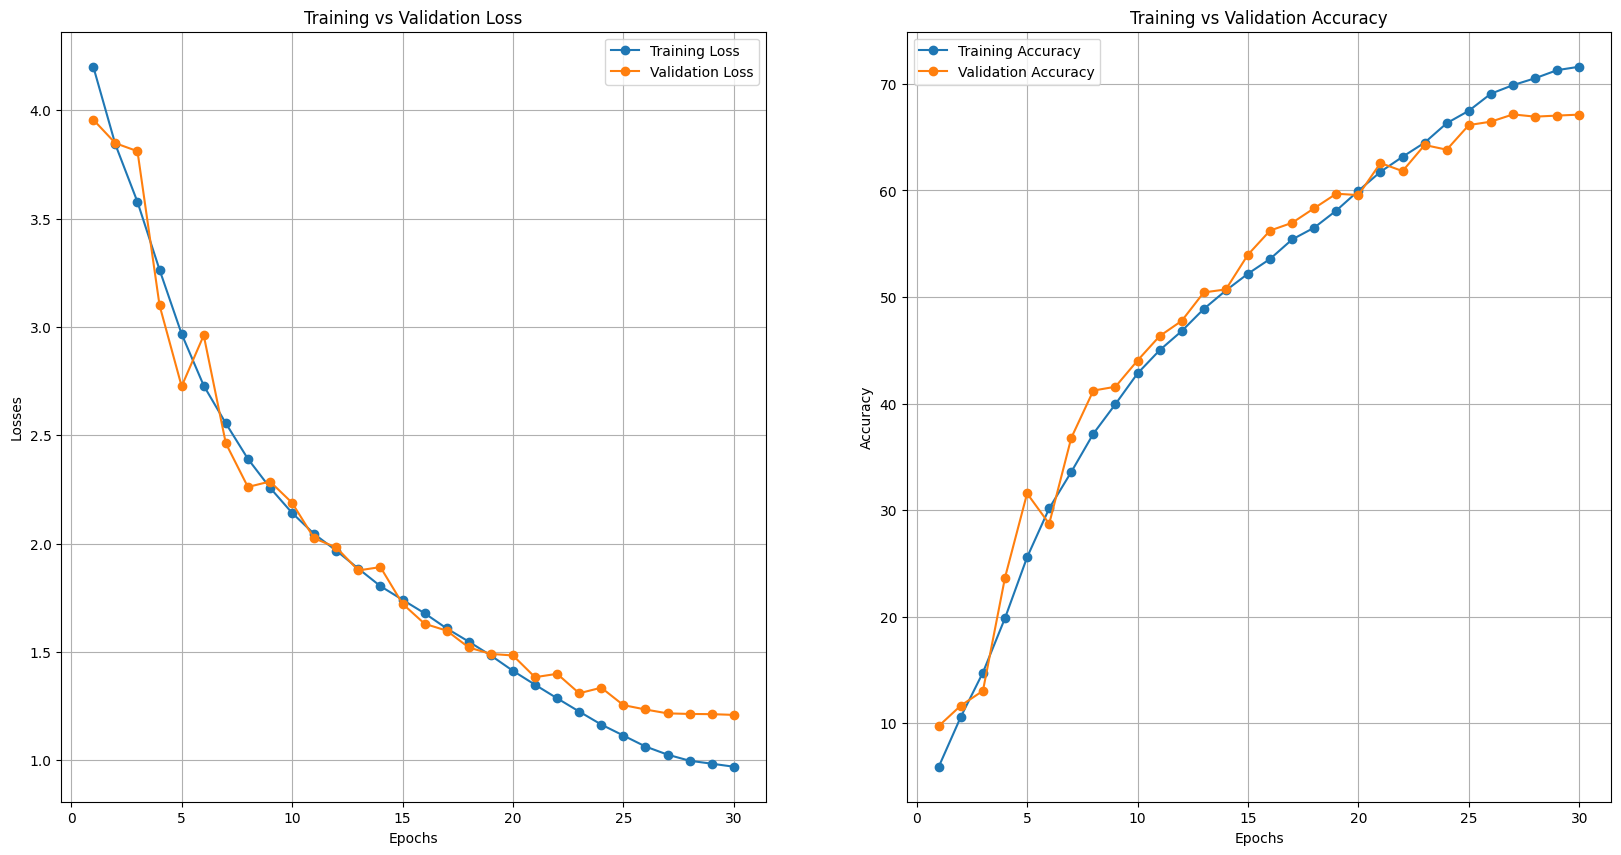

In [22]:
epoch_range = range(1, Epochs+1)
plt.figure(figsize=(20,10))

# Plot the Train and Val Loss
plt.subplot(1,2,1)
plt.plot(epoch_range, train_losses, label = "Training Loss", marker = 'o')
plt.plot(epoch_range, test_losses, label = "Validation Loss", marker = 'o')
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Plot the Train and Val Accuracy
plt.subplot(1,2,2)
plt.plot(epoch_range, train_accs, label = "Training Accuracy", marker = 'o')
plt.plot(epoch_range, test_accs, label = "Validation Accuracy", marker = 'o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.show()

## **Predictions Visualization**
We can visualize the model's predictions to see how it performs on test data.

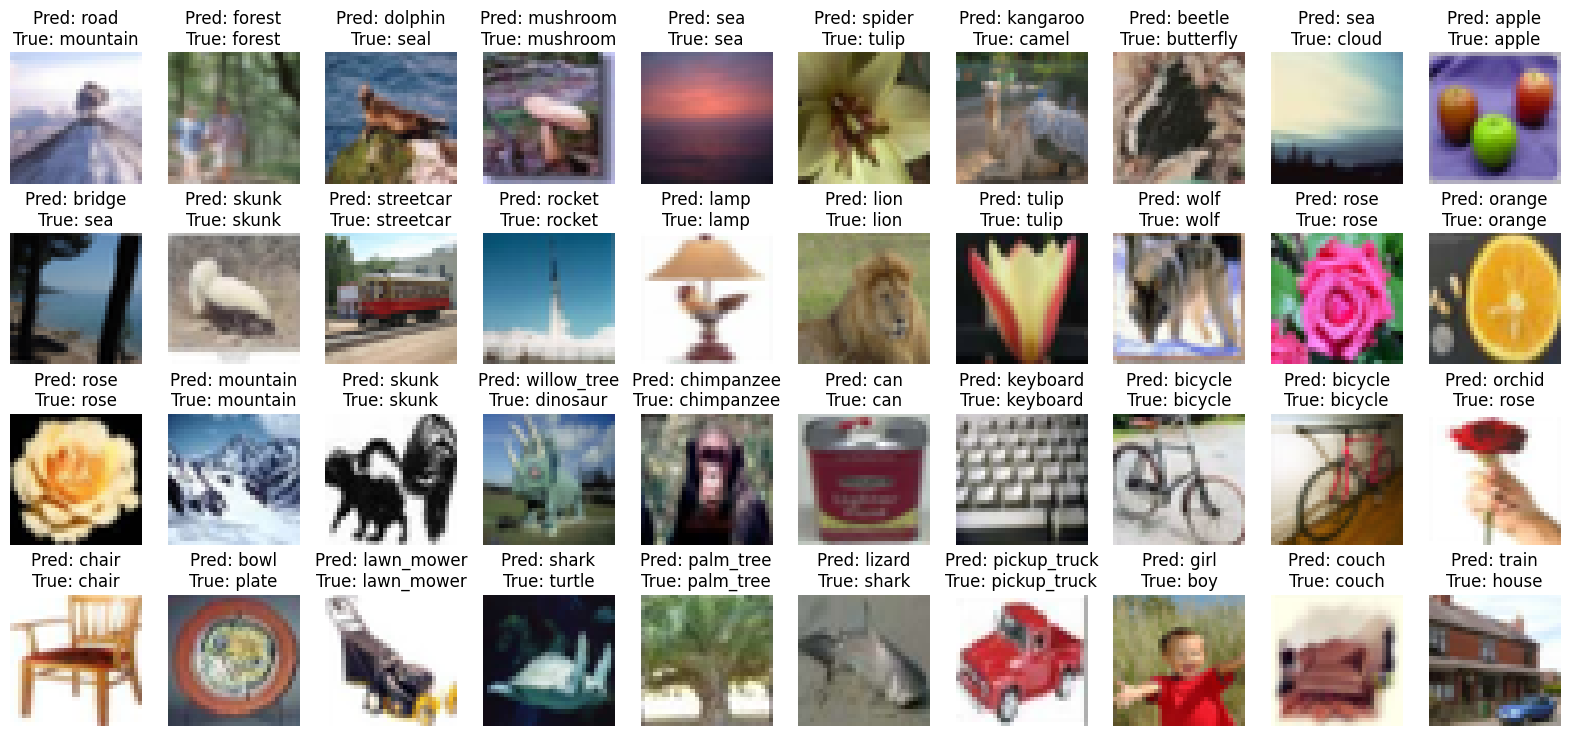

In [23]:
plt.figure(figsize=(20,9))

for i in range (40):
    image, label = test_set[i]
    # Move image to the same device as the model
    image = image.to(device)
    output = model(image.unsqueeze(dim=0))
    pred = output.argmax(dim=1)
    true_name = test_set.classes[label]
    pred_name = test_set.classes[pred]

    image = image.permute(1,2,0).cpu() # Move back to CPU for plotting

    plt.subplot(4,10, i+1)
    plt.imshow(image)
    plt.title(f"Pred: {pred_name}\nTrue: {true_name}")
    plt.axis("off")
plt.show()

## **Confusion Matrix**
It visualizes the model's performance on the testset. And helps to identify which classes the model confuses the most.

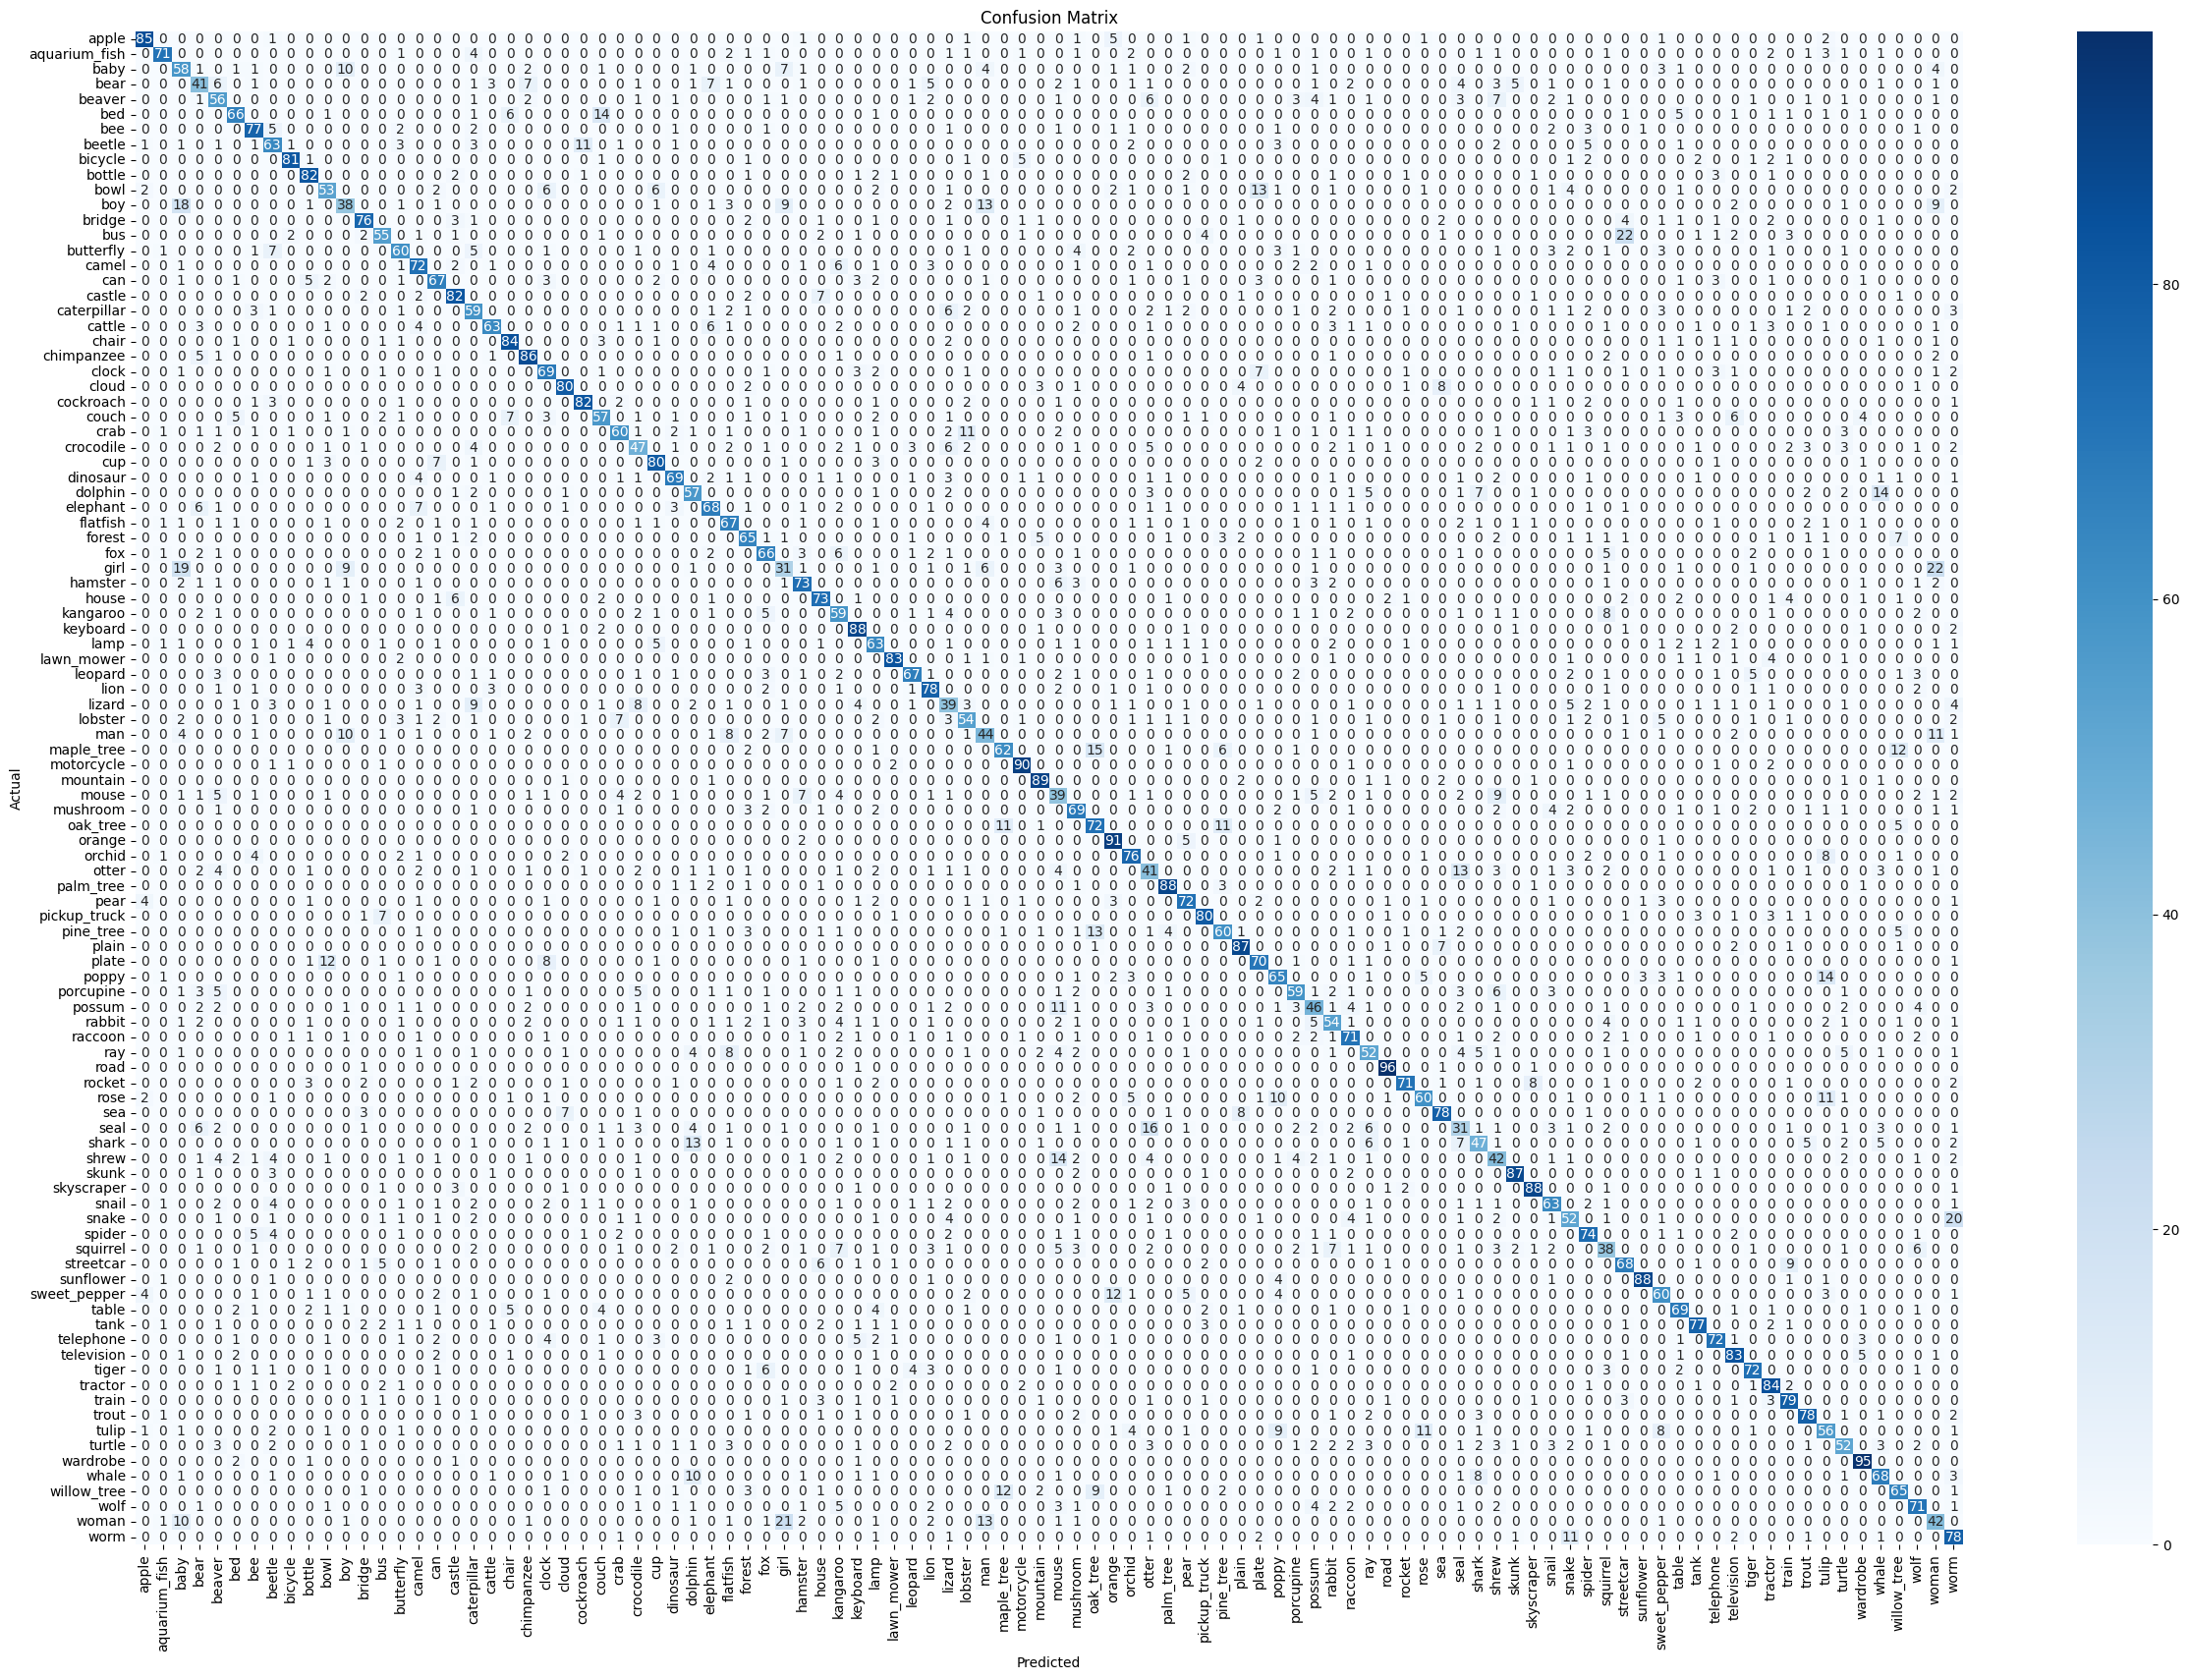

In [24]:
# Collect predictions and true labels
true_labels = []
predictions = []

model.eval()
with torch.inference_mode():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        pred = outputs.argmax(dim=1)
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(pred.cpu().numpy())

# Compute confusion matrix
matrix = confusion_matrix(true_labels, predictions)

# Get class name from label index
class_name = test_set.classes

# Plot heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=class_name, yticklabels=class_name, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## **Latency and Throughput**
We can check the model's inference time (Latency) and samples per second (Throughput) to get performance idea:

In [25]:
# Creating fake batch of images
dummy_samples = torch.ones(256, 3, 32, 32).to(device)

model.eval()
start_time = time.time()

with torch.inference_mode():
    _ = model(dummy_samples)

end_time = time.time()

# Total time per batch
time = end_time - start_time

# Throughput
throughput = 256 / time

print(f"Time Per Batch: {time*1000:.2f} ms")
print(f"Throughput: {int(throughput)} img/sec")

Time Per Batch: 19.44 ms
Throughput: 13168 img/sec
